In [43]:
##############################################
# Modificación de los datos en El Google Drive 
##############################################

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gspread
import io
import os

from statsmodels.tsa.holtwinters import ExponentialSmoothing as expo

from google.oauth2.service_account import Credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaInMemoryUpload
from dotenv import load_dotenv


pd.options.display.float_format = '{:,.2f}'.format

In [44]:


# Cargar variables de entorno
if os.path.exists('.env'):
    load_dotenv('.env', override=True)
else:
    load_dotenv(override=True)

# Configuración desde el .env
CUENTA_DE_SERVICIO = os.getenv("GOOGLE_APP_CREDENTIALS")
FOLDER_ID = os.getenv('CARPETA_DESTINO')
SHEET_NAME = os.getenv('SHEET_NAME')

SCOPES = [
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

creds = Credentials.from_service_account_file(CUENTA_DE_SERVICIO, scopes=SCOPES)
client = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds)

# Carga de los datos
sheet = client.open_by_url('https://docs.google.com/spreadsheets/d/1nM06U44GmBwaLgqhi67t7FIZCetjt9vPtzUDKOialKI/edit?gid=1771030767#gid=1771030767').sheet1
datos = sheet.get_values()
    

In [45]:
# Se convierten los datos en un DataFrame
df = pd.DataFrame(datos[1:], columns=datos[0])
df['NETO'] = df['NETO'].str.replace({'$':'','.':'',',':'.'}).astype(float)


# Serie de tiempo para el pronostcio
df2 = df[['Nº FACTURA','FECHA','NETO']].copy()

df2['FECHA'] = pd.to_datetime(df2['FECHA'])

# Ordenar cronológicamente 
df2.sort_values('FECHA')

# Se crea una columna para manejar las devoluciones en ventas 
df2['MONTO_AJUSTADO'] = np.where(
    df['Nº FACTURA'].str.startswith('FVFVCM'),
    df['NETO'],
    -df['NETO'].astype(float)
)


df_resampled = (
    df2.set_index('FECHA')
    .resample('W-MON')['NETO'].sum()
    .reset_index()
)

serie = df_resampled.set_index('FECHA')['NETO']

# Visulización del dataframe 
serie.head()

C:\Users\Rai De  León\AppData\Local\Temp\ipykernel_14148\2832596061.py:9: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df2['FECHA'] = pd.to_datetime(df2['FECHA'])


FECHA
2025-05-19   20,174,717.09
2025-05-26    8,671,402.33
2025-06-02   20,924,084.25
2025-06-09   14,913,489.60
2025-06-16   24,666,859.69
Name: NETO, dtype: float64

2026-01-05   9,150,121.74
2026-01-12   8,790,403.27
2026-01-19   8,430,684.79
2026-01-26   8,070,966.31
Freq: W-MON, dtype: float64


c:\Users\Rai De  León\Documents\1Projects\CERAMIX\ceramix\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


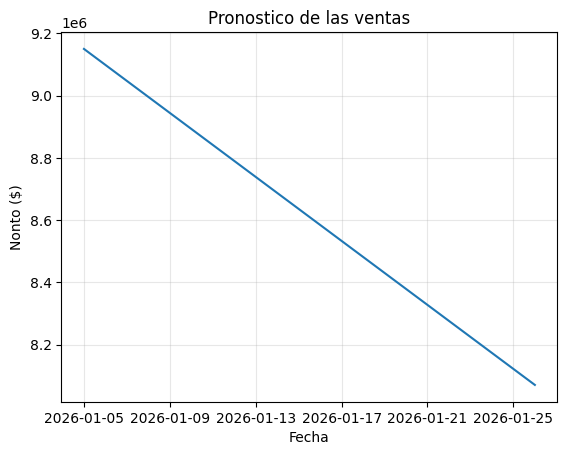

In [53]:
# Entrenamiento del modelo 
modelo_hw = expo(
    serie,
    trend='add',
    seasonal=None,
    initialization_method='estimated'
).fit()

predicion_hw = modelo_hw.forecast(steps=4)
print(predicion_hw)

plt.plot(predicion_hw)
plt.title('Pronostico de las ventas')
plt.xlabel('Fecha')
plt.ylabel('Nonto ($)')
plt.grid(True, alpha=0.3)